In [38]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import wave, sys
import seaborn as sns

from scipy.fft import fft, ifft

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets
import IPython.display as ipd
sns.set()



In [39]:

class Sinus:
    def __init__(self,A,f,time,abtastFeq):
        
        self.FrameRate = 10000
        # t-Werte Sinus
        self.time = np.linspace(0,time,self.FrameRate * time)
        # Amplitude
        self.A = A
        # Frequenz
        self.f = f
        # Abtastrate
        self.abtastFeq = abtastFeq
        
        self.y = self.A * np.sin(2*np.pi*self.f*self.time)
        
        # Abtastsig erzeugen
        self.abtastSignal()
        
    def plot(self):
        fig = plt.figure()
        p = fig.add_subplot(1,1,1)
        p.plot(self.time,self.y)
        
    def abtastSignal(self):
        maxsample = (len(self.y) * self.abtastFeq) / self.FrameRate
        maxsample = int(maxsample)
        self.xAbtast = np.linspace(self.time[0],len(self.y) -1 ,num=maxsample)
        self.abtastSignal =  self.y[self.xAbtast.astype(int)]
        
        # X-Werte generieren, (Messpunkte des Signals) / (Abtastrate) = Zeit in sec.
        self.timeAbtast = np.linspace(
            0,
            len(self.abtastSignal) / self.abtastFeq,
            num = len(self.abtastSignal)
        )
        
        print(maxsample)
        
    def plotAbtast(self):
        fig = plt.figure(figsize=(10,10))
        sigPlot = fig.add_subplot(1,1,1)
        sigPlot.plot(self.timeAbtast,self.abtastSignal,'ro--')
        sigPlot.plot(self.time,self.y)
        
    



In [40]:
class Signal:
    
    def __init__(self,wavDatei):
        
        #Datei einlesen
        self.raw = wave.open(wavDatei)

        #Signal lesen
        self.signal = self.raw.readframes(-1)
        self.signal = np.frombuffer(self.signal, dtype="int16")


        # Abtastrate des Signals bestimmen (Gitarre (s1) : 44100hz)
        self.FrameRate = self.raw.getframerate()

        # X-Werte generieren, (Messpunkte des Signals) / (Abtastrate) = Zeit in sec.
        self.time = np.linspace(
            0,
            len(self.signal) / self.FrameRate,
            num = len(self.signal)
        )

        
    def plotSigZoom(self,x1,x2):

         # Graphen erstellen
        self.fig = plt.figure(figsize=(10,10))
        self.ausgangsSignal = self.fig.add_subplot(2,1,1)
        self.zoomSignal = self.fig.add_subplot(2,1,2)

        # Max Y-Werte, wichtig für gruenen Balken
        self.ymax = np.amax(self.signal)
        self.ymin = np.amin(self.signal)

        # Signale Plotten
        self.ausgangsSignal.plot(self.time,self.signal)
        self.ausgangsSignal.fill_between((x1,x1+x2),self.ymin,self.ymax,facecolor='green',alpha=.5)

        self.zoomSignal.set_xlim(x1,x1 + x2)
        self.zoomSignal.plot(self.time,self.signal)

        plt.show
        
    def plotInteraktiv(self):
        interact(self.plotSigZoom,
        x1=FloatSlider(min=0,max=4,value=0,continuous_update=False),
        x2=FloatSlider(min=.1,max=2,value=0.25,continuous_update=False),
        signal=fixed(self.signal),
        time = fixed(self.time)
        );

    def toAudio(self):
           return ipd.Audio(self.signal,rate=self.FrameRate)
 
    def plotAbtastSigInOriginal(self):
        
        # Graphen erstellen
        self.fig = plt.figure(figsize=(10,10))
        self.ausgangsSignal = self.fig.add_subplot(2,1,1)
        self.zoomSignal = self.fig.add_subplot(2,1,2)
        
        # Signale Plotten
        self.ausgangsSignal.plot(self.time,self.signal)
        self.ausgangsSignal.fill_between((0,0.25),self.ymin,self.ymax,facecolor='green',alpha=.5)
        
        self.zoomSignal.set_xlim(0,0.25)
        self.zoomSignal.plot(self.time,self.signal)
        self.zoomSignal.plot(self.xAbtast,self.abtastSignal,'ro')
        
    # diese Funktion macht die FFT, normiert die Amplituden und plottet alles
    def do_fft(self,x_max):
        fft_x = np.fft.fft(self.signal)
        n = len(fft_x)
        freq = np.fft.fftfreq(n, 1/self.FrameRate)
        half_n = int(np.ceil(n/2.0))
        fft_x_half = (2.0 / n) * fft_x[:half_n]
        freq_half = freq[:half_n]
        fig = plt.figure()
        p = fig.add_subplot(1,1,1)
        p.set_xlim(0,x_max)
        p.plot(freq_half, np.abs(fft_x_half))
        #p.xlabel("Frequency (Hz)")
        #p.ylabel("Amplitude")
        return fft_x
    

In [41]:
class AbtastSignal:
    
    def __init__(self,Signal,abtastFreq):
        self.origSignal = Signal
        self.abtastFreq = abtastFreq
        self.abtastSignal(self.abtastFreq)
        
        # X-Werte generieren, (Messpunkte des Signals) / (Abtastrate) = Zeit in sec.
        self.time = np.linspace(
            0,
            len(self.abtastSignal) / self.abtastFreq,
            num = len(self.abtastSignal)
        )
    
    def abtastSignal(self, abtastFeq):
        maxsample = (len(self.origSignal.signal) * self.abtastFreq) / self.origSignal.FrameRate
        maxsample = int(maxsample)
        self.xAbtast = np.linspace(self.origSignal.time[0],len(self.origSignal.signal) -1 ,num=maxsample)
        self.abtastSignal =  self.origSignal.signal[self.xAbtast.astype(int)]
        
        
    def plotSignal(self):
        plt.plot(self.time,self.abtastSignal)
    
    def plotAbtastSignalInOriginalSignal(self):
        fig = plt.figure(figsize=(10,10))
        sigPlot = fig.add_subplot(1,1,1)
        sigPlot.set_xlim(0,0.05)
        sigPlot.plot(self.time,self.abtastSignal,'ro--')
        sigPlot.plot(self.origSignal.time,self.origSignal.signal)
        
    def toAudio(self):
        return ipd.Audio(self.abtastSignal,rate=self.abtastFreq)


# Das Abtasttheorem

## Einleitung



Bei der folgenden Abbildung handelt es sich um eine Videoaufnahme von einem sich drehenden Propeller. Auffällig ist, dass sich der Propeller sehr langsam zu drehen scheint. Würde man im Flugzeug sitzen und den Propeller mit eigenen Augen beobachten, so würde man die Drehzahl des Propeller anders wahrnehmen. 
Der Grund für die vermeintlich langsame Drehgeschwindigkeit des Propellers im Video, lässt sich auf das Abtasttheorem zurückführen. 
Eine Kamerra erzeugt ein Video, indem es in zeitlich konstanten Abständen, Fotos aufnimmt. Diese Fotos werden im anschluss mit genau diesem zeitlichem Abstand nacheinander abgespielt. Die Frequenz in der die Kamera, Fotos aufnimmt ist dabei so hoch, das es für das menschlichen Auge wie eine flüssige Bewegung aussieht. 
Eine Ausnahme stellt der Propeller dar. Der Propeller dreht sich mit einer höhrene Frequenz als die Kamerra, Fotos aufnimmt. Dadurch verändert sich beim zusammenfügen der Bilder die Frequenz des Propellers. Dieses Phänomen wird als Alias-Effekt bezeichnet. 

![ChessUrl](https://thumbs.gfycat.com/CarelessOilyBug-size_restricted.gif "aliasing")

Folgendes Sinussignal verdeutlich den Alias-Effekt. Die Blau gezeichnete Sinuskurve, stellt das Originalsignal dar. Das Sinussignal hat eine Frequenz von $f_{original} = 6Hz$ und wird mit einer Frequenz von $f_{abtast} = 9Hz$ abgetasttet. Das Abgetastete Signal ist Rot eingezeichnet. 

9


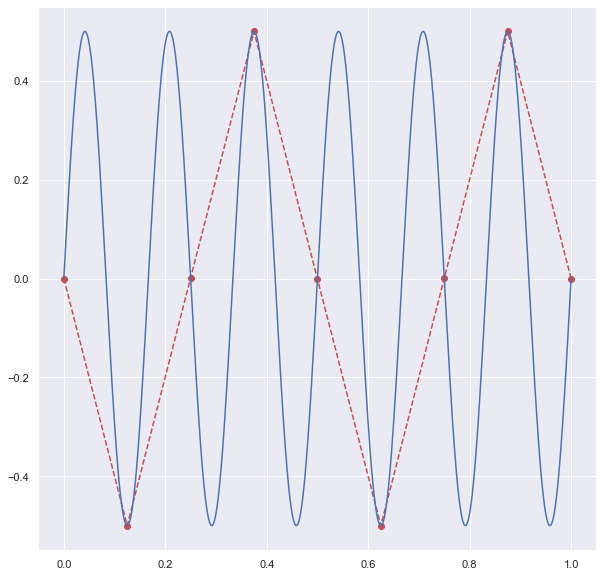

In [42]:
sfalsch = Sinus(A=0.5, f=6, time=1, abtastFeq=9)
sfalsch.plotAbtast()

Es ist erkennbar, das die Frequenz des abgetasteten Signals deutlich geringer ist als die des originalen Signals. 
Wählt man eine Abtastrate von $f_{abtast} = 18Hz$, siehe unteren Plott, so wird die Frequenz des Originalsignals korrekt abgeblidet. 





18


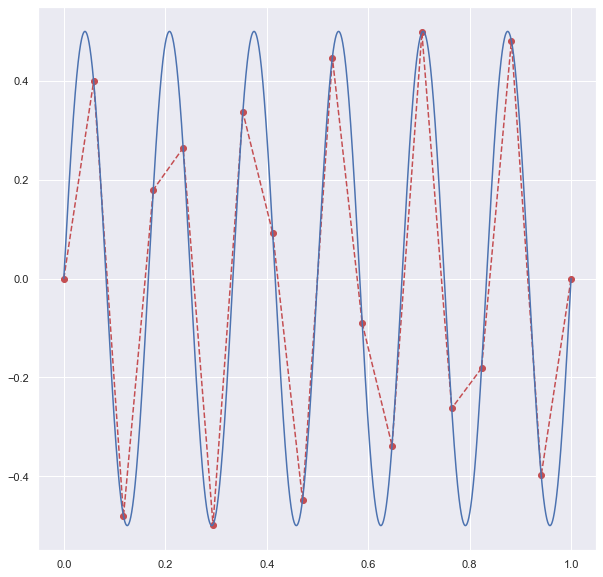

In [43]:
skorrekt = Sinus(A=0.5,f=6,time=1,abtastFeq=18)
skorrekt.plotAbtast()

### Problembeschreibung

Folgende Beispiele legen nahe, dass je höher die Abtastfrequenz ist, umso genau wird das Originalsignal abgebildet.
**Existiert jedoch eine minimale Abtastfrequenz, für ein bestimmtes Signal. Mit dem man das Signal verlusstfrei rekonstruieren kann ?**

Diese Frage spielt besonders in der Digitaltechnik eine zentrale Rolle. Um ein Analogessignal in der Digitaltechnik zu nutzen, muss es diskretisiert werden. Aus effizienz gründen empfehlt es sich nicht eine extrem hohe Abtastfrequenz zu wählen, da somit viel speicherplatz für die diskreten Datenpunkte benötigt werden. 
Diese Fragestellung wurde untersucht und im Nyquist-Shannon-Abtasttheorem festgehalten. 
das abtasttheorem besagt folgendes:

**Eine Funktion, die keine Frequenzen höher $f_{max}$ enthällt, ist durch eine beliebige Reihe von Funktionswerten im  Abstand von $\tau = \frac{1}{2f_{max}}$ eindeutig bestimmt.**

Das Signal aus dem obrigen Beispiel hat eine maximale Frequenz $f_{max} = 6Hz$. Um die Bedingung des Abtasttheorehms zu erfüllen, muss die Abtastfrequenz somit mindestens $f_{abtast} \geq 2*f_{max} \geq 12Hz$ sein, um das Signal verlustfrei zu rekonstruieren. 

# Beispiel anhand eines Klangsignals

Der Klang einer Gitarrenseite ist als Ausgangssignal gegeben. Dadurch das dass Ausgangssignal digital vorliegt, wurde es bereits diskretisiert. 
Die Abtastrate des vorliegenden Signals beträgt $f = 44100Hz$. Diese Abtastfrequenz ist standart für digitale Audiosignale. Der Grund hirfür liegt wider beim Abtasttheorem. Das Menschliche gehör ist nicht in der Lage mehr als $20000Hz$ warzunehmen. Wenn somit ein Audiosignal mit einer Frequenz von $41000Hz$ abgetastet wird, so können alle Frequenzen bis $20500Hz$ rekonstruiert werden, und somit alle für den Menschen höhrbare frequenzen. 

In [44]:
# https://freewavesamples.com/alesis-fusion-nylon-string-guitar-c4
s1 = Signal('./StringGuitar.wav')

Das original Signal wird im folgenden als geplottet. Durch das klicken auf den Playbutton können Sie das Signal Audiosignal höhren und durch die interaktiven Schieberegler im Plot sind Sie in der Lage einzelne Bereiche des Signals vergrößert darzustellen. 

In [45]:
s1.toAudio()

In [46]:
s1.plotInteraktiv()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1', max=4.0), FloatSlider(…

Um das Abtasttheorem auf das Audiosignal anzuwenden, muss die maximale Frequenz des Signals bestimmt werden. Dies ist mithilde der Schnellen Fourier-Transformation (FFT) möglich. Mithilfe der der schnellen Fourier-Transformation, können Signale in ihre Frequenzanteile zerlegt werden. 
Im folgenden Plot werden die Frequenzanteile des Ausgangssignals dargestellt. 

Im Plot wird ersichtlich, dass das Signal über Frequenzanteile im bereich von $20000Hz$ besitzt. Würden wir jedoch dieses $20000Hz$ als maximale Frequenz betrachten, so müsste wir eine Abtastfrequenz von $40000Hz$ wählen. Mit dieser Abtastfrequenz würden wir jedoch das originale Signal eins zu eins abtasten. Unsere neue Abtastrate unterscheidet sich dadurch nur minimal von der originalen Abtastrate. 

Aus dem Plot wird jedoch auch ersichtlich, dass das Signal so gut wie keine Frquenzen im Bereich von $5000Hz - 20000Hz$ besitzt. Somit werden im folgenden die Frequenzen im Bereich von $20000Hz$ ignoriert.

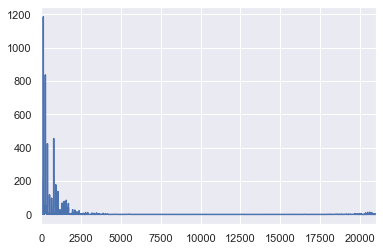

In [47]:
s1.do_fft(21000);

Untersucht man die Frequenzanteile des Signals genauer im bereich von $0 - 7000Hz$, wird ersichtlich, dass das Signal eine maximale Frequenz von ca. $5000Hz$ aufweist. Mit dieser maximalen Frequenz kann das Abtasttheorem angewendet werden. Die minimale Abtastfrequenz beträgt somit $10000Hz$.
Diese Abtastfrequenz ist um ein viertel geringer als die ursprüngliche Abtastfrequenz. Somit reduzieren sich die Datenpunkte um $75\%$

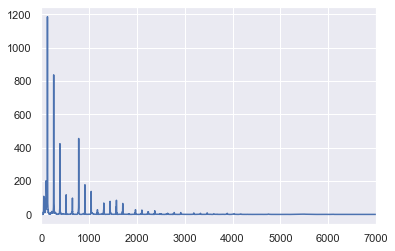

In [48]:
s1.do_fft(7000);

In [49]:
as1 = AbtastSignal(s1,10000)

Im folgenden Plot wird ein geringer Ausschnitt des originalen Signals geplottet. Mit Rot wird in den selben Figure das Abtastsignal geplottet. Es ist gut zu erkennen, dass das Abtastsignal sehr gut mit dem Ausgangssignal übereinstimmt. 

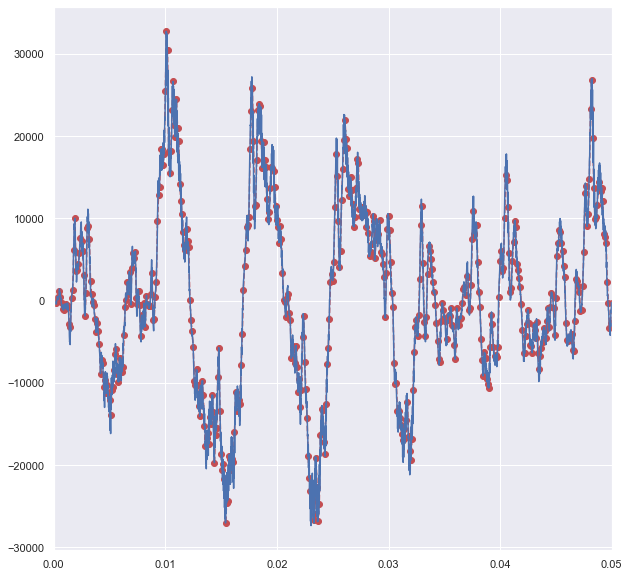

In [50]:
as1.plotAbtastSignalInOriginalSignal()

Im Abschluss können beide Töne abgespielt werden. 

### Ausgangssignal

In [51]:
s1.toAudio()

### Abgetastetesignal

In [52]:
as1.toAudio()

### mit einer zu gringen Frequenz abgetastet. 

In [53]:
as1_schlecht = AbtastSignal(s1,4000)
as1_schlecht.toAudio()

# Zweites Beispiel:

In [54]:
s2 = Signal('./male.wav')

In [55]:
s2.toAudio()

array([-439943.        -6.40284270e-10j,  -44889.96331038+4.34560632e+04j,
         54884.66728204-2.46099687e+04j, ...,
        -24970.1073896 +4.29491041e+04j,   54884.66728204+2.46099687e+04j,
        -44889.96331038-4.34560632e+04j])

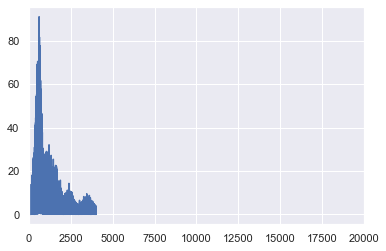

In [56]:
s2.do_fft(20000)

array([-439943.        -6.40284270e-10j,  -44889.96331038+4.34560632e+04j,
         54884.66728204-2.46099687e+04j, ...,
        -24970.1073896 +4.29491041e+04j,   54884.66728204+2.46099687e+04j,
        -44889.96331038-4.34560632e+04j])

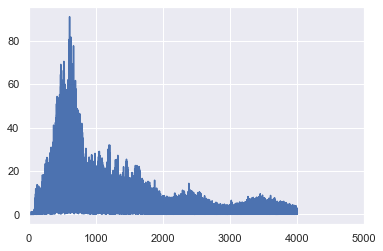

In [57]:
s2.do_fft(5000)

Die Frequenzanalyse des zweiten Signals zeigt, das nur Frequenzen bis $4000Hz$ auftreten. Daher fällt die Wahl der Abtastfrequenz auf $8000Hz$

In [59]:
as2 = AbtastSignal(s2,8000)

In [34]:
as2.toAudio()

Bei nichtzureichendhoher Abtastfrequenz verzerrt sich das Signal folgendermaßen. (Abtastfrequenz $f_{abtast} = 4000Hz$)

In [61]:
as2_schlecht = AbtastSignal(s2, 4000)
as2_schlecht.toAudio()